In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Carga 

In [9]:
X_lr = pd.read_json('processed_for_logistic_regression.json')
X_dt = pd.read_json('processed_for_random_forest.json')
y = pd.read_json('target_variable.json')

# Separación

In [10]:
X_train_lr, X_test_lr, y_train, y_test = train_test_split(
    X_lr, y, test_size=0.2, stratify=y, random_state=12341234)

X_train_dt, X_test_dt, _, _ = train_test_split(
    X_dt, y, test_size=0.2, stratify=y, random_state=12341234)

# Regresión logística

In [11]:


param_grid = {
    'C': [0.01, 0.1, 0.5, 1, 2, 5, 8, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],  
    'class_weight': ['balanced']
}

grid = GridSearchCV(
    estimator=LogisticRegression(max_iter=1000),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train_lr, y_train)

best_logreg = grid.best_estimator_


y_prob = best_logreg.predict_proba(X_test_lr)[:, 1]

thresholds = np.arange(0.3,0.9, 0.05)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_prob >= thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

y_pred = (y_prob >= best_thresh).astype(int)

print("🔍 Optimized Logistic Regression for F1-score")
print("Best Parameters:", grid.best_params_)
print("Best Threshold:", best_thresh)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_prob))

c:\Users\juanm\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


🔍 Optimized Logistic Regression for F1-score
Best Parameters: {'C': 10, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
Best Threshold: 0.7
[[6241  758]
 [ 454 1546]]
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      6999
           1       0.67      0.77      0.72      2000

    accuracy                           0.87      8999
   macro avg       0.80      0.83      0.81      8999
weighted avg       0.87      0.87      0.87      8999

AUC: 0.936378839834262


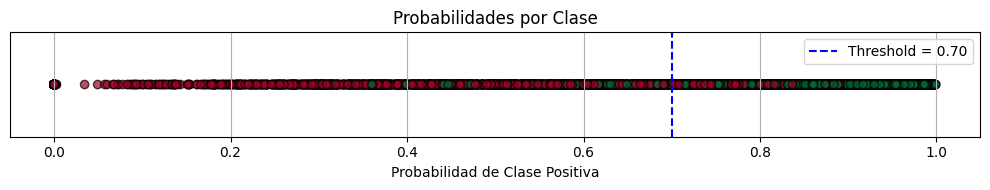

In [12]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10, 2))
plt.scatter(y_prob, [0]*len(y_prob), c=y_test, cmap='RdYlGn', edgecolor='k', alpha=0.7)

# Threshold line
plt.axvline(x=best_thresh, color='blue', linestyle='--', label=f'Threshold = {best_thresh:.2f}')

# Formatting
plt.title("Probabilidades por Clase")
plt.xlabel("Probabilidad de Clase Positiva")
plt.yticks([])  
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
feature_names = X_train_lr.columns

coefficients = best_logreg.coef_[0]  

coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})


coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])


coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)

In [22]:
coef_df

,Feature,Coefficient,Abs_Coefficient
7,previous_loan_defaults_on_file,-5.767858,5.767858
4,loan_percent_income,1.154294,1.154294
3,loan_amnt,-0.441588,0.441588
6,credit_score,-0.440541,0.440541
11,person_home_ownership_OWN,-0.414329,0.414329
13,loan_intent_DEBTCONSOLIDATION,0.269108,0.269108
10,person_home_ownership_MORTGAGE,-0.211890,0.211890
16,loan_intent_MEDICAL,0.202298,0.202298
12,person_home_ownership_RENT,0.188547,0.188547
15,loan_intent_HOMEIMPROVEMENT,0.172883,0.172883


# Árbol de decisión

In [ ]:
param_grid = {
    'max_depth': [3, 4],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced']
}


grid_tree = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=12341234),
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

grid_tree.fit(X_train_dt, y_train)

best_tree = grid_tree.best_estimator_

y_pred_dt_opt = best_tree.predict(X_test_dt)
y_prob_dt_opt = best_tree.predict_proba(X_test_dt)[:, 1]

print("Decision Tree")
print("Best Parameters:", grid_tree.best_params_)
print(confusion_matrix(y_test, y_pred_dt_opt))
print(classification_report(y_test, y_pred_dt_opt))
print("AUC:", roc_auc_score(y_test, y_prob_dt_opt))

Decision Tree
Best Parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
[[4707 2292]
 [   6 1994]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      6999
           1       0.47      1.00      0.63      2000

    accuracy                           0.74      8999
   macro avg       0.73      0.83      0.72      8999
weighted avg       0.88      0.74      0.77      8999

AUC: 0.9219334904986426


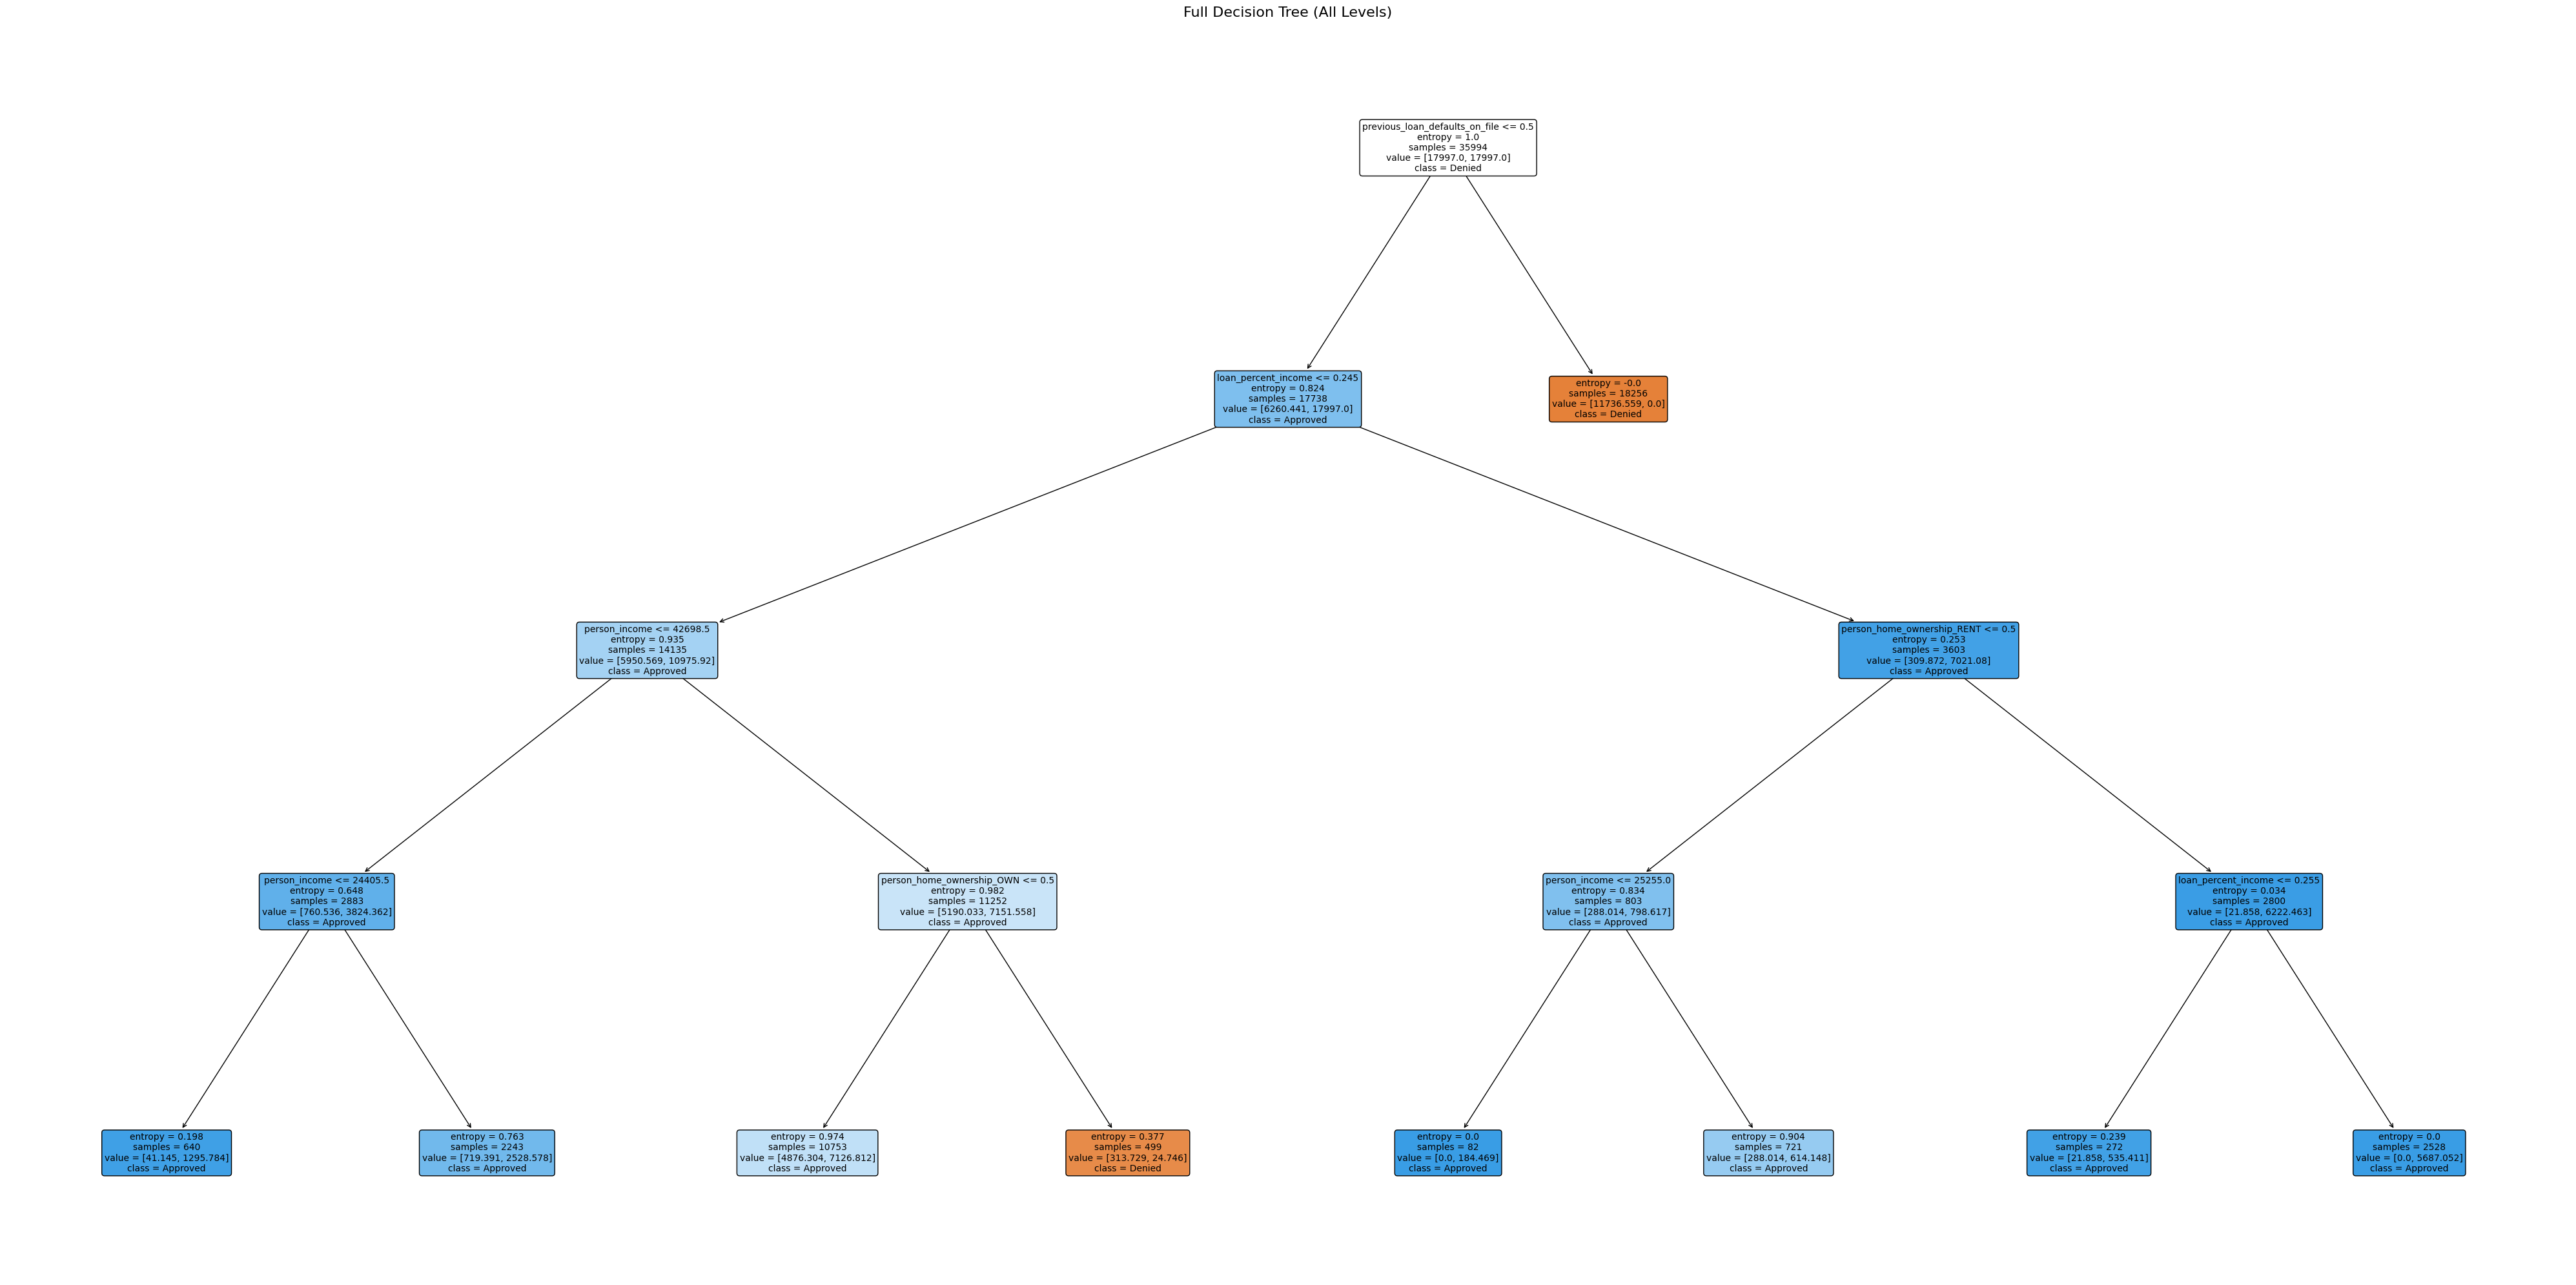

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


plt.figure(figsize=(40, 20))  


plot_tree(
    best_tree,
    feature_names=X_train_dt.columns,
    class_names=['Denied', 'Approved'],
    filled=True,
    rounded=True,
    fontsize=10 
)

plt.title("Arbol de decisión", fontsize=16)
plt.tight_layout()
plt.show()